<a href="https://colab.research.google.com/github/rafaelweinert/DD1420_ML_Excercises/blob/main/Copy_of_Ex5_DD1420.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import sklearn.datasets
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition
import skimage.filters

import torchvision
import torchvision.transforms as T

import scipy.ndimage
import scipy.sparse
import scipy.spatial.distance

from tqdm.notebook import tqdm, trange



# FIX RANDOM SEED
RANDOM_SEED = 239
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED + 1)

%matplotlib inline

# General Instructions

Students are allowed to work on this exercise in pairs. Make sure you have formed a group in Canvas with your partner. Each student is responsible for following the [Code of Conduct](https://kth.instructure.com/courses/32018/pages/code-of-conduct). In particular (1) All members of a group are responsible for the group's work, (2) Every student shall honestly disclose any help received and sources used, and (3) Do not copy from other people's solutions.

If you need assistance with the exercise, you are encouraged to post a question to the appropriate [Discussion Topic](https://kth.instructure.com/courses/32018/discussion_topics) or sign up for a help session.

<br>

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and delete the `raise NotImplementedError()` once you have implemented the solution.

<br>

You should not import any libraries on top of the ones included in the assignment. Derivation questions can be answered using $\LaTeX$, or you may upload an image of your derivation. To do so in *Google Colab* simply create a text cell, click on the `insert image` icon, and upload an image to the notebook as we have demonstrated below.

<br>

**Submission** - once you have completed the exercise make sure everything runs as expected by going into `Runtime` -> `Restart and Run all` then download the notebook by clicking `file` -> `download` -> `download .ipynb`. Then **rename the file to include your name** (and **your partner's name** if you have one) as follows

<br>

`Ex??_LASTNAME_FIRSTNAME_and_LASTNAME_FIRSTNAME.ipynb`

<br>

where you replace `??` with the correct exercise number. If you are working alone you do not need to include a partner name. Correctly naming the file and including your name (and your partner's) below is worth **1 point** - if you fail to correctly name the file or include your partner's name, *you will lose this point*.

<br>

Good luck!

# Name (1 pts)
**Fill in your name and your partner's name below** (and name the `.ipynb` file correctly): <font color="red"> (1 Point) </font>

### Student: LAST, FIRST

### Partner: LAST, FIRST

---

# Exercise 5: Machine Learning and Geometry

In this exercise, we will touch upon the more geometry-oriented side of Machine Learning. In particular, we will focus on dimensionality reduction techniques, investigate the importance of selecting the right metric, and revisit the topic of clustering.

In total, the exercise is worth 25 points.

### 8.0 Data loading

We start by loading an already familiar dataset MNIST of 0-9 digit images. This time we will work with original images of size $(28, 28)$, however for the purpose of the exercise we will only consider a small subset of 500 images of only digits __1__ and __6__.

In [38]:
def load_data():
    # MNIST is conveniently available in the `pytorch` library
    dataset = torchvision.datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]),
    )
    data, labels = dataset.data.numpy(), dataset.targets.numpy()
    data = data.reshape((data.shape[0], -1))
    return data, labels

data, labels = load_data()

image_shape = (28, 28)

# We only consider digits 1 and 6 in this exercise
digit1 = 1
digit2 = 6

data = data[(labels == digit1) | (labels == digit2)]
labels = labels[(labels == digit1) | (labels == digit2)]

# We also only pick the first 500 points from the dataset
N = 500
dim = 28 * 28
data = data[:N]
labels = labels[:N]

# Set the writeable flags to false, we do not want to modify the original data by accident
data.flags.writeable = False
labels.flags.writeable = False

print(f'Data shape: {data.shape}')


Data shape: (500, 784)


Let us also plot a few examples of the images. We will also reuse this function later.

Data examples:


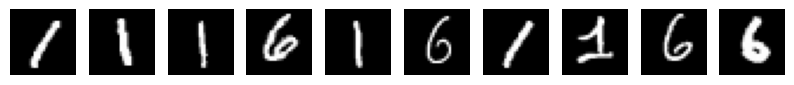

In [39]:
def plot_examples(X, n_samples=10):
    """
    Plot the first few images of the dataset.

    Args:
        X:         data array of size (N, dim)
        n_samples: the number of images to display
    """
    assert X.shape == (N, dim)
    plt.subplots(1, n_samples, figsize=(1 * n_samples, 1))

    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(X[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
    plt.show()

print('Data examples:')
plot_examples(data)

As the final preparation step, here is a simple shortcut method to display a 2-dimensional point cloud in a currently selected plot.

In [40]:
def plot_embedding(embedding, labels, title=None, legend=True):
    """
    Plot the 2-dimensional point cloud.

    Args:
        embedding (ndarray): data array of size (N, 2)
        labels (ndarray):    point labels used for coloring, size (N, )
        title (str):         optional title of the plot
        legend (bool):       whether to include the plot legend
    """
    assert embedding.shape[1] == 2
    scatter = plt.scatter(*embedding.T, c=labels, alpha=0.5, cmap='tab10')
    if legend:
        handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
        plt.legend(handles, labels)
    plt.axis('equal')
    if title is not None:
        plt.title(title)

### 8.1 Dimensionality reduction: Principal Component Analysis (10 points)

We start by looking at the most classical way of performing the dimensionality reduction, performed via Principal Component Analysis, or PCA.

PCA considers the "principal" directions in the input space, along which the data has the highest variation. Those components are given by the eigenvectors of data covariance matrix, and are sorted according to the decreasing order of corresponding eigenvalues.

**Task 8.1.1.** Implement the method `extract_principal_components` below which extracts the projections of the data points onto selected principal components. The method would essentially consist of 3 steps:
1. Compute data covariance matrix
2. Compute eigenvectors of the matrix
3. Compute projection of data onto selected eigenvectors.

Feel free to use the methods for eigenvector computation in `np.linalg` library. The solution only needs less than 10 lines of new code if done efficiently.<font color="red">(4 Points)</font>

In [61]:
def extract_principal_components(X, components):
    """
    Project data points onto specified principal components.

    Args:
        X (np.ndarray):                data array of size (N, dim)
        components (int or list(int)): indices of principal components, starting at 0
    """
    if isinstance(components, int):
        components = [components]

    X_scaled = X - X.mean(axis = 0) # 500 x 784
    cov = np.cov(X_scaled)
    cov = X_scaled.T @ X_scaled # 784 x 784

    eig_val, eig_vec = np.linalg.eig(cov)
    s = eig_val.argsort()
    s = np.flip(s)
    eigenvalues = eig_val[s]
    eigenvectors = eig_vec[s]

    V = eigenvectors[:, components]

    return X_scaled @ V

def apply_pca(X):
    """
    Apply 2-dimensional projection of data using the first two principal components
    """
    return extract_principal_components(X, [0, 1])

**Task 8.1.2.** Compete the code below to compute the variance of our data when projected along each of the first 100 components. <font color="red">(2 Points)</font>

If everything is implemented correctly, the plot should be decreasing with the number of principal components, showing that earlier principal components capture more of the variance than susequent ones.

  0%|          | 0/20 [00:00<?, ?it/s]

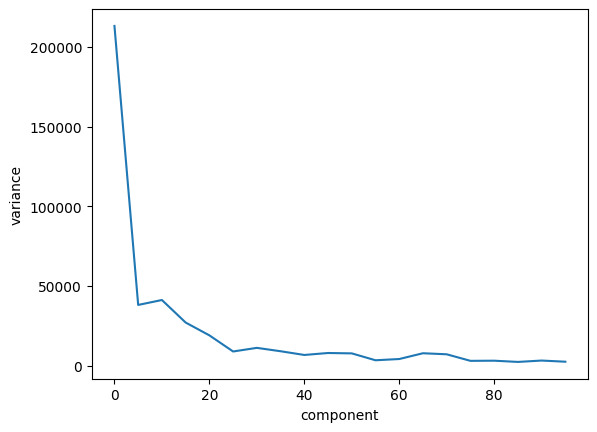

In [62]:
components = range(0, 100, 5)
variances = []
for component in tqdm(components):
    variance = None

    pca = extract_principal_components(data, component)
    variance = np.var(pca)

    variances.append(variance)

plt.plot(components, variances)
plt.xlabel('component')
plt.ylabel('variance')
plt.show()

Now, let us plot some embeddings of our data. We use two different colors to distinguish points of different labels.

The plot on the left is the PCA embedding that uses an implementation of PCA provided in the `scikit-learn` library.

The middle plot is the embedding provided by our own implementation of PCA.

The plot on the right is an embedding, achieved by projecting the points not on the first two components, but on the 10th and the 11th components.

In [ ]:
plt.subplots(1, 3, figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_embedding(sklearn.decomposition.PCA(n_components=2).fit_transform(data), labels, 'scikit-learn', legend=False)
plt.subplot(1, 3, 2)
plot_embedding(apply_pca(data), labels, 'implemented', legend=False)
plt.subplot(1, 3, 3)
plot_embedding(extract_principal_components(data, [10, 11]), labels, 'not principal (10, 11)')
plt.show()

__Task 8.1.3.__ Are the first two embeddings the same? Is the embedding defined uniquely of is there any potential source of randomness in this embedding method, and if there is, what is it? <font color="red">(2 Point)</font>

YOUR ANSWER HERE

__Task 8.1.4.__ What is the main difference between the embedding using the first two components and higher principle components? How would you explain the reason that we see this difference? <font color="red">(2 Points)</font>

YOUR ANSWER HERE

### 8.2 Dimensionality reduction: Multidimensional Scaling (7 points)

Now we will consider another classical and important dimensionality reduction technique, Multidimensional Scaling, or MDS.

Unlike PCA, MDS operates not necessarily on data matrix inself, but on the matrix of pairwise distances between points.

__Task 8.2.1.__ Let us start by implementing the function that computes all euclidean distances between the points. Please implement the method `compute_euclidean_distances` below. <font color="red">(3 Points)</font>

Suggestion: There are methods that can be useful in the package `scipy.spatial.distance`. It is always best to try to avoid explicitly writing for-loops in Python to _vectorize_ the operations, otherwise the code might be running slower.

In [67]:
import scipy.spatial.distance as dist
def compute_euclidean_distances(X):
    """
    Returns all pairwise euclidean distances between the points.
    Args:
        X (np.ndarray): (N, dim) matrix
    Returns:
        D (np.ndarray): (N, N) matrix
    """
    D  = dist.cdist(X, X, metric='euclidean')
    return D

euclidean_distances = compute_euclidean_distances(data)
assert euclidean_distances.shape == (N, N), 'The matrix of pairwise distances should be square!'

__Task 8.2.2.__ Now, let us apply the MDS to our data. Please implement the function below. You may use the ready implementation of MDS available in `scikit-learn`, namely `sklearn.manifold.MDS`. <font color="red">(4 Points)</font>

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


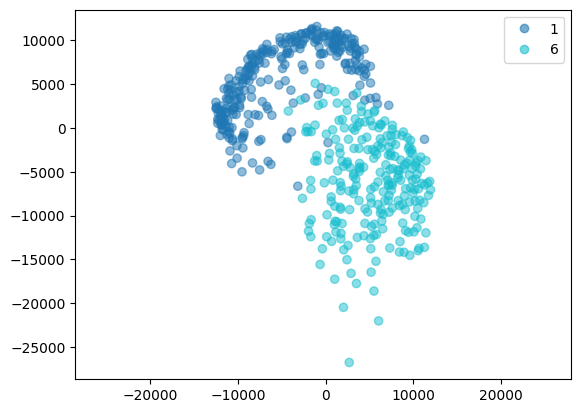

In [68]:
# MDS
from sklearn.manifold import MDS
def apply_mds(distances):
    """
    Given a square distance matrix, returns a two-dimensional MDS embedding.
    Args:
        D (np.ndarray): (N, N) matrix
    Returns:
        E (np.ndarray): (N, 2) matrix
    """
    model = MDS()
    E = model.fit_transform(distances)
    return E

original_mds_embedding = apply_mds(euclidean_distances)
plot_embedding(original_mds_embedding, labels)

### 8.3 Custom distance functions (7 points)

The biggest advantage of MDS compared to PCA is its ability to work with other metrics other than Euclidean.

As a start, let us have a bit deeper look at Euclidean metric and how it operates with images. In order to do this analysis, we will implement a couple of functions: `farthest_pair` and `closest_pair`.
 - `farthest_pair` return a pair of indices of data points of a particular class with the largest distance between them.
 - `closest_pair` return a pair of indices of data points of two different classes with the shortest distance between them.

Farthest pair implementation is already provided and serves as an example of a vectorized implementation that utilizes some more advanced methods and indicing in `numpy`.

__Task 8.3.1.__ Please implement the closest pair method. Feel free to use the same technique as in `farthest_pair` or write your own. <font color="red">(2 Points)</font>

In [63]:
def farthest_pair(distances, labels, label1):
    """
    Args:
        distances (np.ndarray): (N, N) distance matrix
        labels (np.ndarray):    (N, ) label array
        label1 (int):           class to consider
    Returns:
        i, j (int, int):        indices of two most distant points of class label1
    """
    # IMPORTANT copy the distances matrix before changing it!
    distances = distances.copy()

    distances[~(labels == label1), :] = np.nan
    distances[:, ~(labels == label1)] = np.nan
    distances[range(N), range(N)] = np.nan
    flat_index = np.nanargmax(distances)
    return np.unravel_index(flat_index, distances.shape)

def closest_pair(distances, labels, label1, label2):
    """
    Args:
        distances (np.ndarray): (N, N) distance matrix
        labels (np.ndarray):    (N, ) label array
        label1 (int):           class #1
        label2 (int):           class #2
    Returns:
        i, j (int, int):        indices of two closest points between class label1 and class label2
    """
    # IMPORTANT copy the distances matrix before changing it!
    distances = distances.copy()

    distances[~(labels == label1), :] = np.nan
    distances[:, ~(labels == label2)] = np.nan
    #distances[range(N), range(N)] = np.nan
    flat_index = np.nanargmin(distances)
    return np.unravel_index(flat_index, distances.shape)

Here are some helper functions to display the results of the functions above, as well as to show the distribution of all pairwise distances between elements of two selected classes.

In [64]:
def plot_closest_pair(distances, labels, label1, label2):
    i, j = closest_pair(distances, labels, label1, label2)

    print(f'Closest pair between digits {label1} and {label2}')
    print(f'Distance: {distances[i, j]:.3f}')

    plt.subplots(1, 2, figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(data[i].reshape(image_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(data[j].reshape(image_shape), cmap='gray')

    plt.show()

def plot_farthest_pair(distances, labels, label1):
    i, j = farthest_pair(distances, labels, label1)

    print(f'Farthest pair of digits of {label1}')
    print(f'Distance: {distances[i, j]:.3f}')

    plt.subplots(1, 2, figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(data[i].reshape(image_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(data[j].reshape(image_shape), cmap='gray')

    plt.show()

def plot_pairwise_distances(distances, labels, label1, label2):
    max_distance = np.max(distances[labels == label1, :][:, labels == label2])
    bins = np.linspace(0, max_distance, 51)
    plt.hist(distances[labels == label1, :][:, labels == label1].flatten(),
               bins=bins, alpha=.5, label=f'{label1}-{label1}')
    plt.hist(distances[labels == label1, :][:, labels == label2].flatten(),
               bins=bins, alpha=.5, label=f'{label1}-{label2}')
    plt.legend()
    plt.suptitle('Pairwise distance distribution')
    plt.show()

Let us have a look at two closest images between __1__ and __6__, and two most distinct images of __1__. Additionally, we display the distribution of distances between different images of __1__ and __6__ and between __1__ and __1__ on the histogram below.

Closest pair between digits 1 and 6
Distance: 1158.288


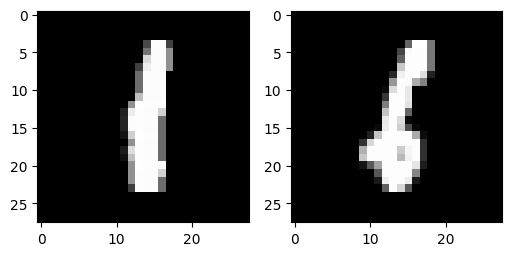

Farthest pair of digits of 1
Distance: 2940.740


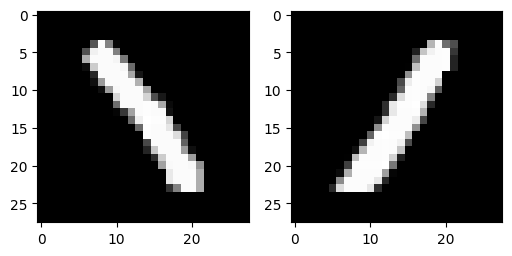

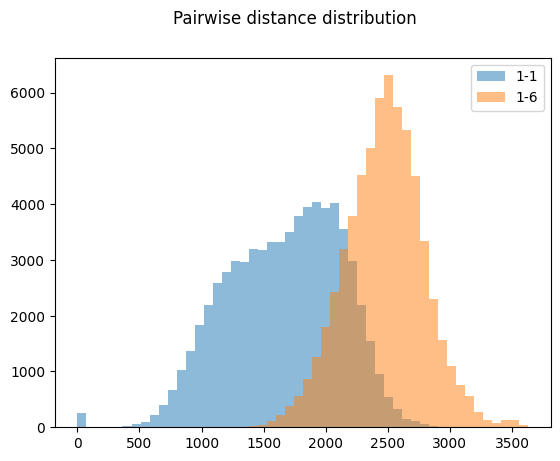

In [69]:
plot_closest_pair(euclidean_distances, labels, digit1, digit2)
plot_farthest_pair(euclidean_distances, labels, digit1)
plot_pairwise_distances(euclidean_distances, labels, digit1, digit2)

If the implementation `closest_pair` is correct, the image of __1__ and of __6__ should look rather similar.

When we look at two images of __1__, even though the digits look quite similar geometrically, they are angled differently. This results in large pixel-wise Euclidean distance between the images.

Let us try to build a metric that considers different rotations of an image!

__Task 8.3.2.__ First, we need a method that rotates all images to a certain angle. Please implement the method below, the `angle` parameter is provided in degrees, and its sign defines the direction of rotation (you can pick either clockwise or counter-clockwise direction as "positive"). <font color="red">(2 Points)</font>

_Hint:_ consider using `scipy.ndimage.rotate` for rotation, and be sure to set `reshape=False` for the function in order to keep the scale of images the same.   

The small code after the function wil help you verify that the rotations are implemented correctly.

In [81]:
print(data.shape)
print(len(data))
print(data[0].shape)

(500, 784)
500
(784,)


Rotation angle: -45


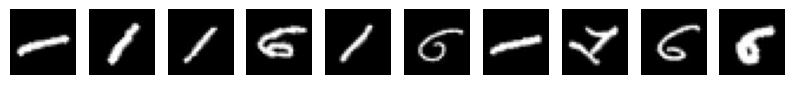

Rotation angle: -30


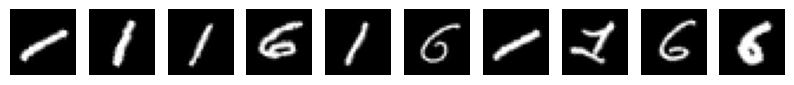

Rotation angle: -15


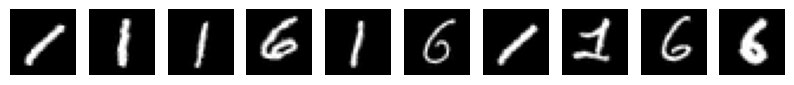

Rotation angle: 0


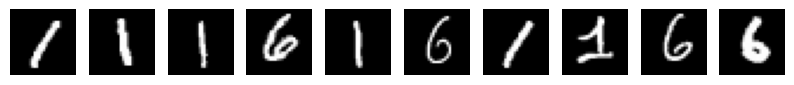

Rotation angle: 15


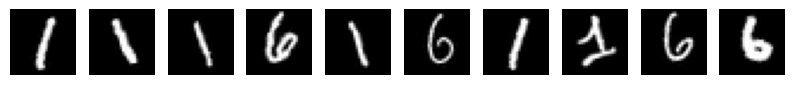

Rotation angle: 30


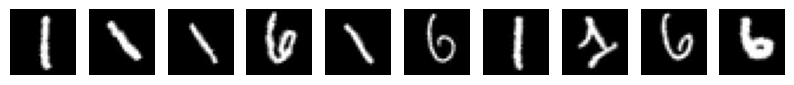

Rotation angle: 45


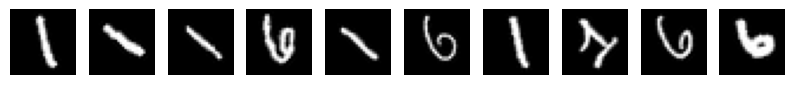

In [85]:
from scipy.ndimage import rotate as rot
def rotate(X, angle):
    R = np.zeros((X.shape))
    for i in range(len(data)):
      img = rot(X[i].reshape(28,28), angle, reshape=False).flatten()
      R[i] = img
    return R
    #raise NotImplementedError()

angle_list = [-45, -30, -15, 0, 15, 30, 45]
for angle in angle_list:
    print(f'Rotation angle: {angle}')
    plot_examples(rotate(data, angle))


Now let us define a similarity measure between two images $I$ and $J$ for a set of rotation angles $\mathcal{A}$ as the following:

$$\text{sim}(I, J) = \min_{\alpha \in \mathcal{A}}\lVert{I - \text{rotate}(J, \alpha)}\rVert_2$$

where $\lVert \cdot \rVert_2$ denotes the Euclidean distance we have been using so far.

__Task 8.3.3.__ Please implement this similarity function below. Note that the function computes the full square matrix of pairwise similarities. Like for Euclidean distances computation, we recommend to utilize the methods in `scipy.spatial.distance` for pairwise distances.

In addition, please make sure that the resulting similarity matrix $M$ is __symmetric__, which can be ensured by taking the coordinate-wise average between $M$ and $M^T$ in the end. <font color="red">(2 Points)</font>

In [87]:
print(np.ones((5, 5)) * np.inf)

[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]


In [91]:
def compute_rotation_invariant_similarity(X, angle_list):
    """
    Returns all pairwise rotational similarities between the points.
    Args:
        X (np.ndarray):           (N, dim) matrix
        angle_list (list(float)): list of all rotation angles in degrees
    Returns:
        D (np.ndarray):           (N, N) similarity matrix
    """
    # YOUR CODE HERE
    min_D = np.ones((len(X), len(X))) * np.inf
    for angle in angle_list:
      rX = rotate(X, angle)
      D = dist.cdist(X, rX, metric='euclidean')
      min_D = np.minimum(D, min_D)
    min_D = np.average(np.array([min_D, min_D.T]), axis = 0)
    return min_D

rotation_invariant_similarities = compute_rotation_invariant_similarity(data, np.linspace(-90, 90, 15))
assert rotation_invariant_similarities.shape == (N, N), 'Similarity matrix should have size (N, N)'
assert np.all(rotation_invariant_similarities == rotation_invariant_similarities.T), 'Similarity matrix is not symmetric!'

There is a reason we used a word "similarity" instead of "distance" or "metric" in our definition above. This is due to the fact that the function above does not follow the definition of metric. In fact, it is something that is called __pseudo-metric__. The way a pseudo-metric is different from a metric is that _it allows the distance between distinct points to be zero_ (i.e. $\text{sim}(I, J) = 0$ is allowed for $I \neq J$).

__Task 8.3.4.__ Could you briefly explain why exactly the rotation similarity is not be a metric in general sense? <font color="red">(1 Point)</font>

YOUR ANSWER HERE

For simplicity, we will also call this similarity a _distance_ from now on. To be fair, this pseudo-metric can still be considered a proper metric, but on _classes of equivalent images_.

Let us plot the image pairs again, now according to rotation similarity, as well as a new distance histogram.

Closest pair between digits 1 and 6
Distance: 1116.073


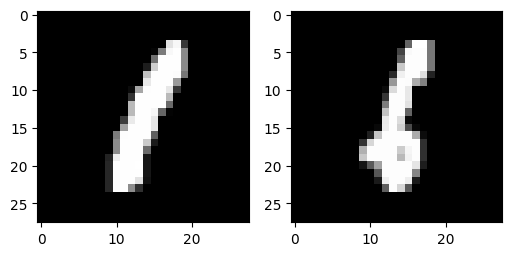

Farthest pair of digits of 1
Distance: 2450.854


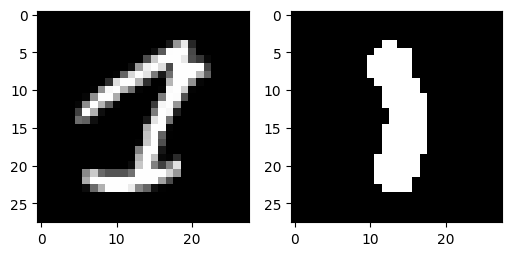

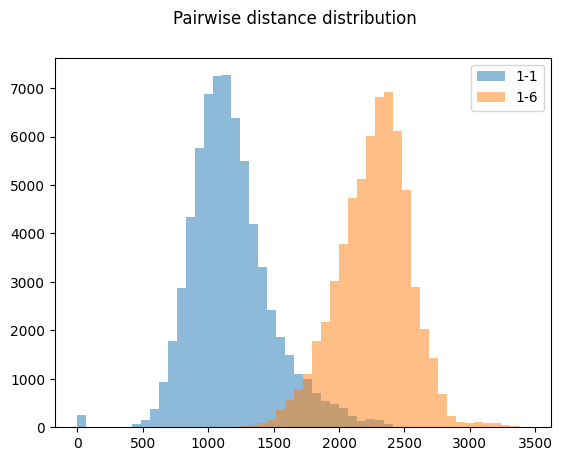

In [92]:
plot_closest_pair(rotation_invariant_similarities, labels, digit1, digit2)
plot_farthest_pair(rotation_invariant_similarities, labels, digit1)
plot_pairwise_distances(rotation_invariant_similarities, labels, digit1, digit2)

We can notice that now the most distinct images of `1` are not as similar looking anymore. Moreover, without context, one might assume that those images are of two completely different characters, and those definitely can't be handled by a rotations.

Additionally, the histograms of pairwise distances look more separate than before! This hints us that we might have successfully separated images of `1` and `6` from each other distance-wise.

Finally, let us plot the two embeddings, one with classical MDS already considered earlier, and one with MDS on rotational similarities.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalize

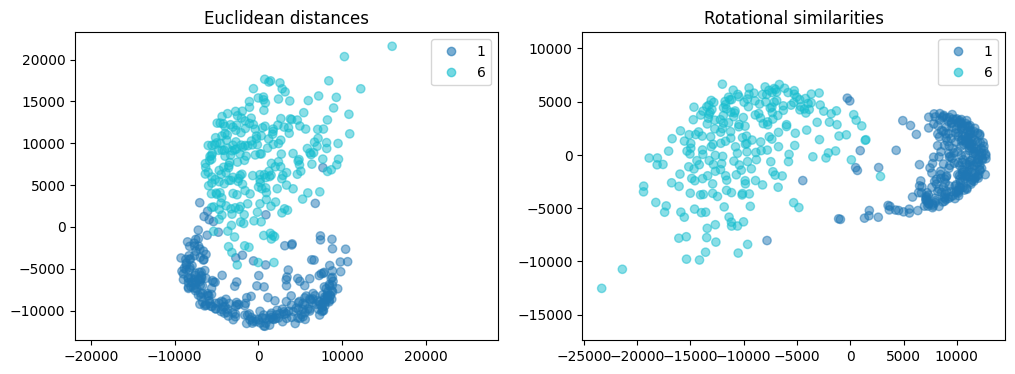

In [93]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_embedding(apply_mds(euclidean_distances), labels, 'Euclidean distances', legend='False')
plt.subplot(1, 2, 2)
plot_embedding(apply_mds(rotation_invariant_similarities), labels, 'Rotational similarities')

The new embedding should look a bit better separated. Also, the digits of __1__ (dark blue dots) appear more clustered together.